In [18]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import functions

import warnings
warnings.filterwarnings("ignore")


In [19]:
# DATA preprocessing:

# set a pair and time period 
pair = 'EUR_USD'
granularity = 'H1'  #granularity in OANDA format
pip = 0.0001        # set pip value of the pair
year = 2021     # select only year of interest

# import data as datafreme
df = pd.read_pickle( f"hist_data/{pair}_{granularity}.pkl" )

# keeping numeric format of prices 
not_num_cols = ['volume','time']
num_col = [x for x in df.columns if x not in not_num_cols ]
df[num_col] = df[num_col].apply(pd.to_numeric)

# set time of the candle as index and keep only year of interest
df.index = pd.to_datetime(df.time)
df = df[df.index.year == year]

# spread
df['Spr'] = (df.ask_c - df.bid_c)

# keep only midle prices, renaming columns and dropiing unused
df.rename(columns = {'volume':'Volume','mid_o':'Open','mid_c':'Close','mid_l':'Low','mid_h':'High','time':'Date'}, inplace=True)
df = df.drop(['bid_o', 'bid_h', 'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c'],axis=1)

print('Number of candles', len(df))
print('Columns: \n', df.columns)


Number of candles 6238
Columns: 
 Index(['Date', 'Volume', 'Open', 'High', 'Low', 'Close', 'Spr'], dtype='object')


In [20]:
# Get the short day trend: whether current price is above o below day opening price

# create dataframe with dates only 
df['Dates'] = df.index.date
index_list =sorted(set(df['Dates']))
df_1D = pd.DataFrame( index = index_list, columns = [ 'Open' ]  )
df_1D.Open = [ df['Open'][ df.Dates == idx ][0] for idx in index_list ]

# create a columne with an opening price of the date 
df['Date_start'] = np.nan 
for date in df_1D.index:
    df.Date_start[(date.year == df.index.year) & (date.month == df.index.month) \
                   & (date.day == df.index.day)] = df_1D.Open[ df_1D.index == date ][0]
df['Date_start'].ffill( inplace = True)

# create short trend of the day: 1 - if current price above day open, -1 - if current price below day open
df['Short_trend'] = np.where( df.Date_start < df.Close, 1, 0 )
df['Short_trend'] = np.where( df.Date_start > df.Close, -1, df.Short_trend )

In [21]:
df

,Date,Volume,Open,High,Low,Close,Spr,Dates,Date_start,Short_trend
time,,,,,,,,,,
2021-01-03 22:00:00+00:00,2021-01-03T22:00:00.000000000Z,184,1.22400,1.22427,1.22324,1.22342,0.00063,2021-01-03,1.22400,-1
2021-01-03 23:00:00+00:00,2021-01-03T23:00:00.000000000Z,1623,1.22339,1.22528,1.22310,1.22500,0.00017,2021-01-03,1.22400,1
2021-01-04 00:00:00+00:00,2021-01-04T00:00:00.000000000Z,2930,1.22498,1.22498,1.22388,1.22409,0.00016,2021-01-04,1.22498,-1
2021-01-04 01:00:00+00:00,2021-01-04T01:00:00.000000000Z,3149,1.22410,1.22558,1.22400,1.22527,0.00014,2021-01-04,1.22498,1
2021-01-04 02:00:00+00:00,2021-01-04T02:00:00.000000000Z,2640,1.22526,1.22586,1.22496,1.22542,0.00015,2021-01-04,1.22498,1
...,...,...,...,...,...,...,...,...,...,...
2021-12-31 17:00:00+00:00,2021-12-31T17:00:00.000000000Z,1729,1.13790,1.13864,1.13774,1.13863,0.00014,2021-12-31,1.13222,1
2021-12-31 18:00:00+00:00,2021-12-31T18:00:00.000000000Z,828,1.13862,1.13862,1.13748,1.13847,0.00014,2021-12-31,1.13222,1
2021-12-31 19:00:00+00:00,2021-12-31T19:00:00.000000000Z,619,1.13849,1.13858,1.13798,1.13827,0.00014,2021-12-31,1.13222,1


## Book Strategies:

### BOOK STRATEGY 1: two SMMA + Bollinger Band

**For Buy/Long Entry:**

    Entry long trade when a candle closes above the top bollinger band
    3 SMMA crosse above 5 SMMA
    Candle close price is above day open price
    Stop loss and Take profit = 20 pips

**For Sold/Short Entry:**

    Entry short trade when a candle closes below the bottom bollinger band
    3 SMMA crosse below 5 SMMA
    Candle close price is below day open price
    Stop loss and Take profit = 20 pips

FINAL RETURN :  97.75 
MAX RETURN:  100.45 
MIN RETURN:  97.40 
Wins:  73 ; Losses:  76 ; Win rate:  0.49
Average profit in pips:  18.6 ; Average loss in pips:  21.4


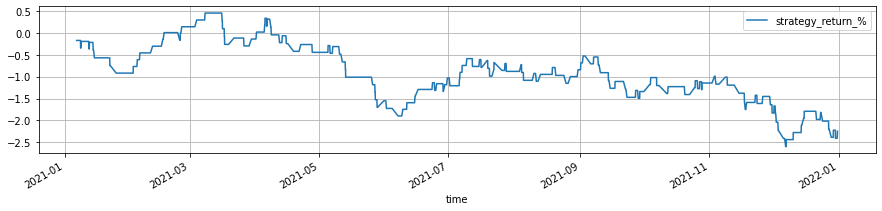

In [22]:
# set indicators values:
# two SMMA
df['SMMA_3'] = ta.smma(df.Close,3)
df['SMMA_5'] = ta.smma(df.Close,5)
# Bol. band
df['BB'] = ta.ema(df.Close,20)
df['BB_up'] = df.BB + 0.8*df.Close.rolling(20).std() 
df['BB_down'] = df.BB - 0.8*df.Close.rolling(20).std() 

# booline arrays whether the entring conditions satisfied - 1, or not 0  
enter_long_1 =  np.where( ( df.BB_up.shift() > df.Close.shift() ) & ( df.BB_up < df.Close ) \
                        & ( df.SMMA_3 > df.SMMA_5 ) & ( df.SMMA_3.shift() < df.SMMA_5.shift() ) \
                        & ( df.Short_trend == 1) 
                          , 1,  0)
                
enter_short_1 = np.where( ( df.BB_down.shift() < df.Close.shift() ) & ( df.BB_down > df.Close ) \
                        & ( df.SMMA_3 < df.SMMA_5 ) & ( df.SMMA_3.shift() > df.SMMA_5.shift() ) \
                        & ( df.Short_trend == -1)
                         , 1,  0)

# set a stop price and take profit price (array)
stop_price = df.Close*0 + 20*pip
exit_price = df.Close*0 + 20*pip

# trading simulator enters long/short position if condition is satisfied and exit when stop prise/exit price is reached
Strategy_1 = functions.trade_simulator(df.Close, df.High, df.Low, df.Spr, 
                                        enter_long_1, 
                                        enter_short_1,  
                                        take_profit = exit_price, 
                                        stop_loss = stop_price, 
                                      )
df['Position'] = Strategy_1[1]
df['Win_loss'] = Strategy_1[0]

functions.strategy_outcome(df, 'Win_loss', 'Position')

### BOOK STRATEGY 2: Stochasticcs + SMA + RSI

**For Buy/Long Entry:**

    Entry long trade when price crosses above the moving average
    The Stochasticcs are above 50 and cross below
    RSI crosses above level 70
    Candle close price is above day open price
    Stop loss and Take profit = 20 pips

**For Sold/Short Entry:**

    Entry long trade when price crosses above the moving average
    The Stochasticcs are below 50 and cross up
    RSI crosses below level 30
    Candle close price is below day open price
    Stop loss and Take profit = 20 pips


FINAL RETURN :  95.96 
MAX RETURN:  100.59 
MIN RETURN:  95.68 
Wins:  66 ; Losses:  80 ; Win rate:  0.452
Average profit in pips:  18.6 ; Average loss in pips:  21.4


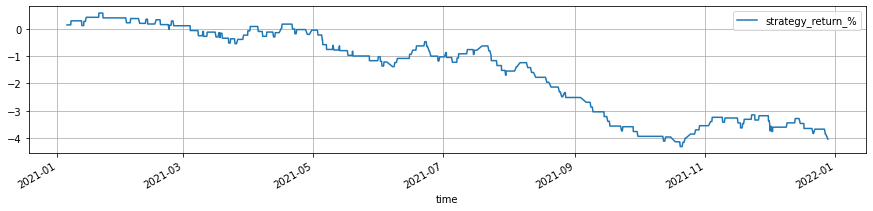

In [23]:
df['RSI_3'] = ta.rsi(df.Close, 3)
df['SMA'] = ta.sma(df.Close, 12)

Stochstics = ta.stoch(close = df.Close, high=df.High,low=df.Low, k=12, d = 3, smooth = 4)
df['STOCHk'] = Stochstics.iloc[:,0]
df['STOCHd'] = Stochstics.iloc[:,1]
df['STOCHh'] = Stochstics.iloc[:,2]

enter_long_2 = (df.SMA < df.Close) & (df.SMA.shift() > df.Close.shift()) \
                & (df.RSI_3 > 70) & (df.RSI_3.shift() < df.RSI_3) \
                & (df.STOCHk < 50) & (df.STOCHh > 0) & ( df.Short_trend == 1)

enter_short_2 = (df.SMA > df.Close) & (df.SMA.shift() < df.Close.shift()) \
                & (df.RSI_3 < 30) & (df.RSI_3.shift() > df.RSI_3) \
                & (df.STOCHk > 50) & (df.STOCHh < 0) & ( df.Short_trend == -1)

Strategy_2 = functions.trade_simulator(df.Close, df.High, df.Low, df.Spr, 
                                        enter_long_2, 
                                        enter_short_2,  
                                        take_profit = exit_price, 
                                        stop_loss=stop_price, 
                                        )

df['Position'] = Strategy_2[1]
df['Win_loss'] = Strategy_2[0]

functions.strategy_outcome(df, 'Win_loss', 'Position')


___

## Feature generator:

The **Pair_test** class generates features for potential trading opportunities by performing a search over a selected year and simulating strategy performance. The process involves several steps:

- Import data for a given pair, year, and granularity.
- Perform data preprocessing.
- Apply numerous technical indicators, resulting in two boolean columns ("enter_long" and "enter_short") for each indicator, that take value "True" when the conditions for a long or short position are met.
- Calculate **Labels_2**. Label is a variable with two classes (1 and -1) based on expected future profit for each candle. Variable is setting the label to 1 if future prices reach the **close price+expected profit** before **close price-expected profit** and to -1 if the opposite occurs.
- Search through all possible strategies, each of which consists of a combination of three indicator entry conditions.

A strategy is kept if:

    (Labels=1 | Strategy=1)/sum(Strategy=1) > threshold rate AND (Labels=-1 | Strategy=-1)/sum(Strategy=-1) > threshold rate.

In [24]:
from feature_generator import Pair_tester

pair = 'EUR_USD'
granularity = 'H1'  #granularity in OANDA format
path = 'hist_data/' #path to a data directory

pip = 0.0001

# ATR multiplier and length for expected profit
atr_coef = 2
atr_length = 8

#threshold rate, which strategies to keep, must be <0.5  
threshold = 0.60

In [25]:
test_2021 = Pair_tester(path, pair, granularity, pip, year = 2021)
test_2021.apply_bunch_of_indicators( )

profit = ta.atr(high=test_2021.df.High, low=test_2021.df.Low, close=test_2021.df.Close, length=atr_length)*atr_coef
test_2021.get_labels(profit)

test_2021.run_indicators_search(threshold=threshold)

print( "Number of positive (long) and negative (short) upcomming labels:" )
print(test_2021.df.Labels_2.value_counts())

Number of potential strategies:  15
Number of positive (long) and negative (short) upcomming labels:
-1.0    3268
 1.0    2956
Name: Labels_2, dtype: int64


In [26]:
# best strategies:
# Indicator_1, Indicator_2, Indicator_3 - names of strategy's indicators
# long_luck_ratio - rates of Labels_2 == 1 predicted rightly by strategy long entry condition
# shirt_luck_ratio - rates of Labels_2 == -1 predicted rightly by strategy short entry condition
# short_opps - number of short trades opportunities
# long_opps - number of long trades opportunities

test_2021.best_strategies.head(10)

,Indicator_1,Indicator_2,Indicator_3,short_luck_ratio,long_luck_ratio,short_opps,long_opps
2078,STOCH,STOCHRSI,Quantiles,0.656250,0.714286,32,21
1739,RSI_3,CMF,ROC,0.633333,0.692308,30,26
2480,CMF,ROC,ADX,0.736842,0.625000,19,16
1875,MACD,CMF,ROC,0.666667,0.777778,15,9
2100,STOCH,CMF,ROC,0.785714,0.666667,14,9
2454,KC,ADX,PSAR,0.642857,0.666667,14,15
1990,AO,KC,PSAR,0.777778,0.642857,9,14
846,SMMA_2_cross,BB_1,supertrend,0.666667,0.900000,6,10
2095,STOCH,KC,PSAR,0.833333,0.666667,6,9
2140,STOCH,supertrend,support_resist,0.666667,0.800000,6,10


FINAL RETURN :  101.85 
MAX RETURN:  101.97 
MIN RETURN:  99.71 
Wins:  30 ; Losses:  17 ; Win rate:  0.638
Average profit in pips:  21.8 ; Average loss in pips:  25.4


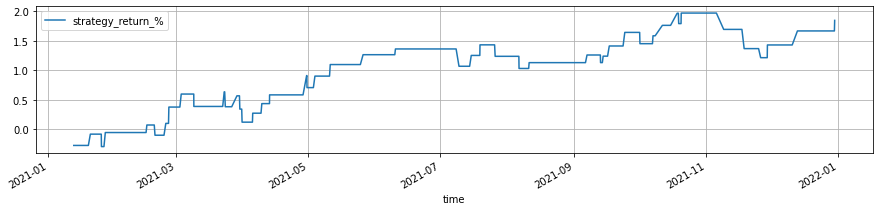

In [27]:
# Checking the first best strategy:
strat_to_check = 0

Indicator_1 = test_2021.best_strategies.Indicator_1.iloc[strat_to_check]
Indicator_2 = test_2021.best_strategies.Indicator_2.iloc[strat_to_check]
Indicator_3 = test_2021.best_strategies.Indicator_3.iloc[strat_to_check]

enter_condition_long = np.where(  test_2021.df[Indicator_1+'_enter_long'] \
                                & test_2021.df[Indicator_2+'_enter_long'] \
                                & test_2021.df[Indicator_3+'_enter_long']  , 1,  0) 

enter_condition_short = np.where( test_2021.df[Indicator_1+'_enter_short'] \
                                & test_2021.df[Indicator_2+'_enter_short'] \
                                & test_2021.df[Indicator_3+'_enter_short']  , 1,  0)

test_2021.set_enter_condition( enter_condition_long, enter_condition_short )
test_2021.set_stop_loss_vector( profit)
test_2021.set_take_profit_vector(profit)

test_2021.run_simulator()
test_2021.strategy_plot()


### I will be rich!
## Test strategies on a new time period :

In [28]:
# create pair tester for the next period
test_2022 = Pair_tester(path, pair, granularity, pip, year = 2022)
test_2022.apply_bunch_of_indicators( )

profit = ta.atr(high=test_2022.df.High, low=test_2022.df.Low, close=test_2022.df.Close, length=atr_length)*atr_coef
test_2022.get_labels(profit)
print( "Number of positive (long) and negative (short) upcomming labels:" )
test_2022.df.Labels_2.value_counts()


Number of positive (long) and negative (short) upcomming labels:


-1.0    3042
 1.0    2767
Name: Labels_2, dtype: int64

FINAL RETURN :  101.54 
MAX RETURN:  101.54 
MIN RETURN:  97.73 
Wins:  24 ; Losses:  22 ; Win rate:  0.522
Average profit in pips:  41.3 ; Average loss in pips:  38.3


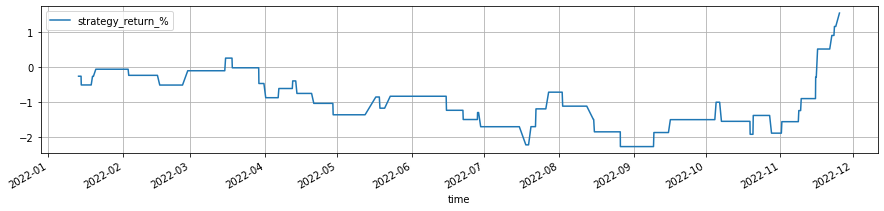

In [29]:
# Let's check the first best strategy FROM THE PREVIOUS PERIOD:

enter_condition_long = np.where(  test_2022.df[Indicator_1+'_enter_long'] \
                                & test_2022.df[Indicator_2+'_enter_long'] \
                                & test_2022.df[Indicator_3+'_enter_long']  , 1,  0) 

enter_condition_short = np.where( test_2022.df[Indicator_1+'_enter_short'] \
                                & test_2022.df[Indicator_2+'_enter_short'] \
                                & test_2022.df[Indicator_3+'_enter_short']  , 1,  0)

test_2022.set_enter_condition( enter_condition_long, enter_condition_short )
test_2022.set_stop_loss_vector( profit )
test_2022.set_take_profit_vector( profit )

test_2022.run_simulator()
test_2022.strategy_plot()

### I won't be rich quite yet...

## SUPPORT VECTOR MACHINE (SVM) MODEL:
### Feature engineering:

In [30]:
# creating a dataframe with best strategies from PREVIOUS YEAR enter conditions: 1 - long opportunity, -1 - short opportunity:
strategies_num = len(test_2021.best_strategies)

X = test_2022.df[['Labels_2']].copy()

strategies_list = []
for i in range(0, strategies_num):
    
    enter_condition_long =    test_2022.df[test_2021.best_strategies.iloc[i,0]+'_enter_long'] \
                            & test_2022.df[test_2021.best_strategies.iloc[i,1]+'_enter_long'] \
                            & test_2022.df[test_2021.best_strategies.iloc[i,2]+'_enter_long'] 
            
    enter_condition_short =   test_2022.df[test_2021.best_strategies.iloc[i,0]+'_enter_short'] \
                            & test_2022.df[test_2021.best_strategies.iloc[i,1]+'_enter_short'] \
                            & test_2022.df[test_2021.best_strategies.iloc[i,2]+'_enter_short'] 
    
    X['Strategy_'+str(i)] = np.where( enter_condition_long, 1,  0)
    X['Strategy_'+str(i)] = np.where( enter_condition_short, -1,  X['Strategy_'+str(i)])
    strategies_list.append('Strategy_'+str(i))

X = X.loc[~(X[strategies_list]==0).all(axis=1)]
X.dropna(inplace=True)

print( 'Number features: ',X.shape[1]-1 )
print( 'Number of non-zero cases: ', len(X))

Number features:  15
Number of non-zero cases:  194


### Model training:

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import accuracy_score

train_set = int(len(X)*0.80)

y_train = X.iloc[ :train_set,0].copy()
X_train = X.iloc[:train_set,1:].copy()

y_test = X.iloc[train_set:,0].copy()
X_test = X.iloc[train_set:,1:].copy()

sv = svm.SVC(kernel='linear', class_weight='balanced')
sv.fit(X_train , y_train)

y_hat_train = sv.predict(X_train)
y_hat_test = sv.predict(X_test)

print('TRAIN Accuracy: %0.3f' % accuracy_score(y_hat_train, y_train) )
print('TRAIN Confusion matrix: \n', confusion_matrix(y_hat_train, y_train), '\n')

print('TEST Accuracy: %0.3f' % accuracy_score(y_hat_test, y_test) )
print('TEST Confusion matrix: \n', confusion_matrix(y_hat_test, y_test) )

TRAIN Accuracy: 0.613
TRAIN Confusion matrix: 
 [[44 26]
 [34 51]] 

TEST Accuracy: 0.513
TEST Confusion matrix: 
 [[ 8  5]
 [14 12]]


### Evaluation:

FINAL RETURN :  101.45 
MAX RETURN:  102.04 
MIN RETURN:  100.29 
Wins:  20 ; Losses:  14 ; Win rate:  0.588
Average profit in pips:  29.4 ; Average loss in pips:  31.7


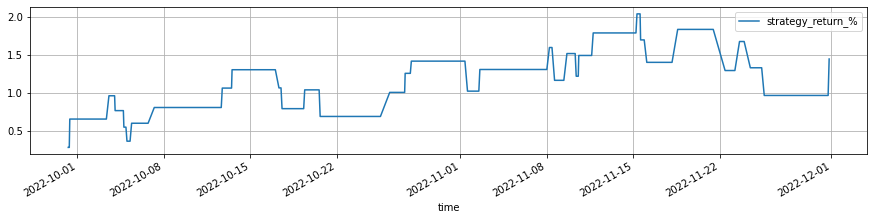

In [32]:
test_2022.get_best_strategies_from_df( test_2021.best_strategies )

test_time = X.index[train_set]
test_set_2022 = test_2022.df[test_2022.df.index > test_time].copy()
test_set_2022['Predicition'] = 0
non_zero_indicators = ~(test_set_2022[strategies_list]==0).all(axis=1)
test_set_2022['Predicition'][non_zero_indicators] = sv.predict(test_set_2022[strategies_list][non_zero_indicators])

enter_long_sv =  np.where( test_set_2022['Predicition'] == 1 , 1,  0)
enter_short_sv = np.where( test_set_2022['Predicition'] == -1, 1,  0)
                
Strategy_sv = functions.trade_simulator(test_set_2022.Close, test_set_2022.High, test_set_2022.Low, test_set_2022.Spr, 
                                        enter_long_sv, 
                                        enter_short_sv,  
                                        take_profit = profit, 
                                        stop_loss = profit, 
                                    )

test_set_2022['Position'] = Strategy_sv[1]
test_set_2022['Win_loss'] = Strategy_sv[0]

functions.strategy_outcome(test_set_2022, 'Win_loss', 'Position')



___